### Лабораторная работа 5

#### Приближение функций

Прокопьев Григорий <br>
Вариант 21: 5.1.21, 5.2.4, 5.6.11, 5.8.2

Замечание: в таблице вариантов вместо 5.6.11 указано 5.5.11 $-$ опечатка

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

#### Задача 5.1.21

Функция  $y = f(x)$ задана таблицей  значений  $y_0, y_1,\dots,y_n$   в точках  $x_0, x_1,\dots,x_n$ . Используя метод наименьших квадратов (МНК), найти многочлен $$P_m(x) = a_0 + a_1 x + \cdots + a_m x^m$$ наилучшего среднеквадратичного приближения оптимальной степени $m = m^*$. За оптимальное значение $m^*$ принять ту степень многочлена, начиная с которой величина 
$$\sigma_m = \sqrt{\frac{1}{n - m} \sum_{k=1}^n \left( P_m(x_k) - y_k \right)^2}$$ стабилизируется или начинает возрастать.

1) Задание векторов исходных данных:

In [2]:
x = np.arange(0, 3.25, 0.25)
y = np.array([-2.815, -2.18, -0.225, 1.722, 3.492, 3.31, 2.945, 1.449, 0.334, -1.906, -3.430, -2.983, 0.087])

2) Составление и решение нормальной системы наименьших квадратов:

Design matrix в нашем случае имеет вид:
$$A = \begin{pmatrix} 1 & x_1 & x_1^2 &\dots & x_1^m\\
                      1 & x_2 & x_2^2 &\dots & x_2^m\\
                      \vdots & \vdots&\vdots&&\vdots\\
                      1 & x_n & x_n^2 &\dots & x_n^m\\ \end{pmatrix}$$
Функция, которая ее возвращает:

In [3]:
def get_design_matrix(x, m):
    x_arr = np.array(x)
    A = np.empty((len(x), m+1))
    for i in range(m+1):
        A[:, i] = x_arr**i
    
    return A

Нормальная система для метода наименьших квадратов имеет вид:
$$ A^T A \vec\beta = A^T y, $$
где $\vec\beta$ $-$ вектор коэффициентов аппроксимирующего многочлена <br>

Функция, возвращающая решение системы:

In [4]:
def solve_normal_equations(A, y, residual = False):
    # residual = True: функция вернет сумму квадратов остатков
    y_arr = np.array(y)
    coeffs = np.linalg.solve(A.T @ A, A.T @ y_arr)
    if residual:
        res = A @ coeffs - y_arr
        return coeffs, res @ res
    else:
        return coeffs

При $residual = True$ функция вернет сумму квадратов остатков, т.е.
$ \sum_{k=1}^n \left( P_m(x_k) - y_k \right)^2 $

2.1) Нахождение коэффициентов многочленов $P_m, m = 0, 1, 2, \dots, 12$ из нормальной системы и вычисление соотвествующих им $\sigma_m$:

In [5]:
M = 12

coeffs_res = []
for m in range(M+1):
    coeffs_res.append( solve_normal_equations(get_design_matrix(x, m), y, residual=True) )

sigma = list(map(lambda c:  np.sqrt(c[1] / (len(x) - len(c[0]) + 1)), coeffs_res))

где: $ \sigma_m = \sqrt{\frac{1}{n - m} \sum_{k=1}^n \left( P_m(x_k) - y_k \right)^2} $

P.S. нет смысла брать $M \geq 13$, так как $n = 13$ и тогда $n - m \leq 0$ 

3) Гистограмма зависимости $\sigma_m$ от $m$:

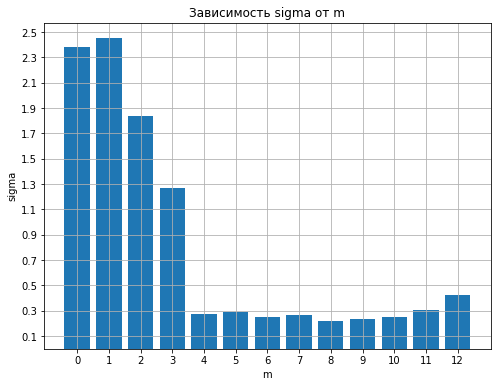

In [6]:
plt.figure(figsize=(8, 6))
plt.bar(list(range(M+1)), sigma)
plt.xticks(list(range(M+1)))
plt.yticks(list(np.arange(0.1, 2.7, 0.2)))
plt.xlabel('m')
plt.ylabel('sigma')
plt.title('Зависимость sigma от m')
plt.grid()
plt.show()

Как видно за оптимальную степень многочлена $m^*$ можно принять $m = 8$, так как далее $\sigma_m$ начинает возрастать

In [7]:
m_opt = 8

4) Графики получившихся многочленов:

In [8]:
coeffs = [c[0] for c in coeffs_res]

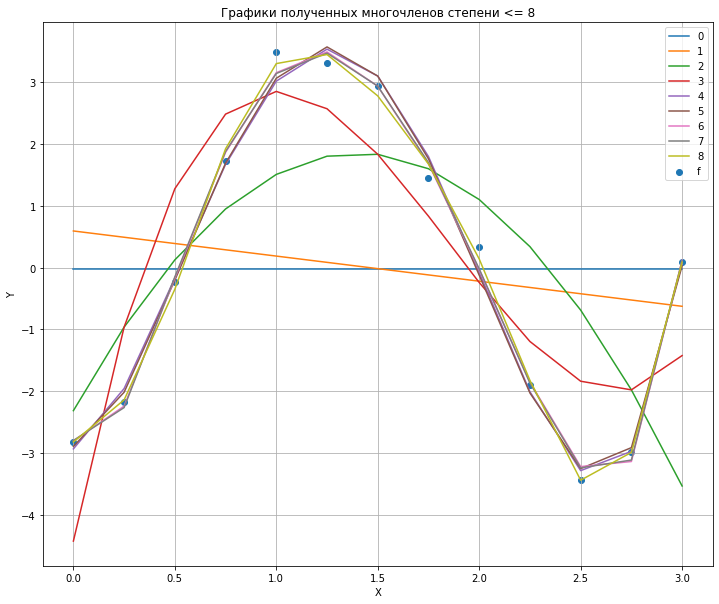

In [9]:
plt.figure(figsize=(12, 10))
plt.scatter(x, y, label = 'f')

for i, c in enumerate(coeffs[:m_opt+1]):
    poly = np.poly1d(c[::-1])
    plt.plot(x, poly(x), label = i)

    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Графики полученных многочленов степени <= 8')
plt.grid()
plt.legend()
plt.show()

5) Решение задачи МНК через QR разложение:

In [10]:
coeffs_qr = []
for m in range(M+1):
    q, r = np.linalg.qr(get_design_matrix(x, m), mode='complete')
    r1 = r[:m+1]
    y1 = np.dot(q.T, y)[:m+1]
    coeffs_qr.append(np.linalg.solve(r1, y1))

Разница между коэффициентами, полученными с помощью решения нормальной системы МНК и QR разложения:

In [11]:
print ("{:<8} {:<16} {:<14} {:<10}".format('m','abs. diff.','res.','sigma'))
for i in range(len(coeffs)):
    # разница по модулю между коэффициентами:
    abs_diff = np.abs(coeffs_qr[i] - coeffs[i]).sum()
    # аппроксимирущий многочлен и остаток:
    poly = np.poly1d(coeffs_qr[i][::-1])
    res_qr = (poly(x) - y) @ (poly(x) - y)
    # СКО:
    sigma_qr = np.sqrt(res_qr/(len(x) - len(coeffs_qr[i]) + 1))
    
    print ("{:<2} {:16.9f} {:14.9f} {:14.9f}".format(i, abs_diff, res_qr, sigma_qr))

m        abs. diff.       res.           sigma     
0       0.000000000   74.027397077    2.386297375
1       0.000000000   72.150153912    2.452042582
2       0.000000000   37.190175323    1.838729189
3       0.000000000   16.141582532    1.270495279
4       0.000000000    0.690261854    0.276939996
5       0.000000000    0.669979500    0.289391495
6       0.000000343    0.433367895    0.248816598
7       0.000007361    0.429893225    0.267673067
8       0.000947815    0.236593906    0.217528806
9       0.077347169    0.217984604    0.233444107
10     48.048325713    0.183838917    0.247547246
11   5964.975982742    0.183487698    0.302892471
12 519391.972085928    0.000000000    0.000000067


Как видно, для полиномов степени $\geq 7$ абсолютная разница между коэффициентами становится существенной, в то время как остаток (разница между значениями многочлена и функции) и СКО (среднее квадратичное отклонение)  для QR метода становятся все меньше.

Сравнительные графики полученных полиномов:

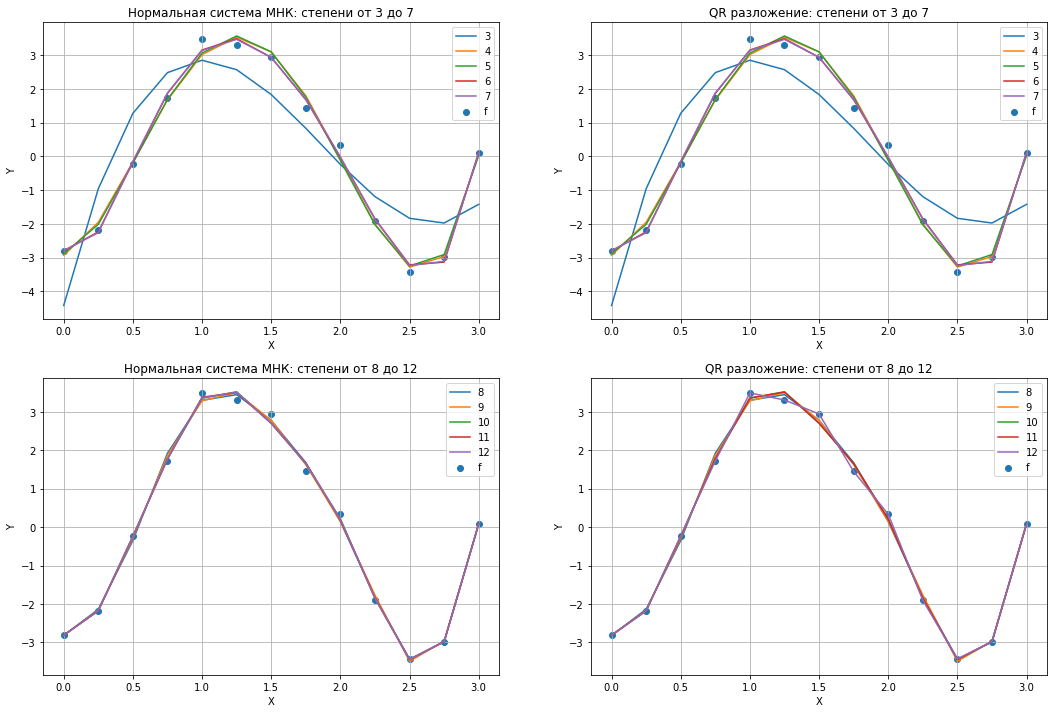

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

ax[0, 0].scatter(x, y, label = 'f')
ax[0, 1].scatter(x, y, label = 'f')
ax[1, 0].scatter(x, y, label = 'f')
ax[1, 1].scatter(x, y, label = 'f')

for i, (c, c_qr) in enumerate(zip(coeffs, coeffs_qr)):
    if i < 3:
        continue
    poly = np.poly1d(c[::-1])
    poly_qr = np.poly1d(c_qr[::-1])
    if i <= 7:
        ax[0, 0].plot(x, poly(x), label=i)
        ax[0, 1].plot(x, poly_qr(x), label=i)
    else:
        ax[1, 0].plot(x, poly(x), label=i)
        ax[1, 1].plot(x, poly_qr(x), label=i)

for a in ax.flatten():
    a.legend()
    a.grid()
    a.set_xlabel('X')
    a.set_ylabel('Y')
    
ax[0, 0].set_title('Нормальная система МНК: степени от 3 до 7')
ax[0, 1].set_title('QR разложение: степени от 3 до 7')
ax[1, 0].set_title('Нормальная система МНК: степени от 8 до 12')
ax[1, 1].set_title('QR разложение: степени от 8 до 12')
plt.show()

Это видно и на графиках: многочлены более высоких степеней, полученные через QR разложение, аппроксимируют функцию лучше.

Ухудшение точности аппроксимации через решение нормальной системы МНК можно объяснить плохой обусловленностью design matrix:

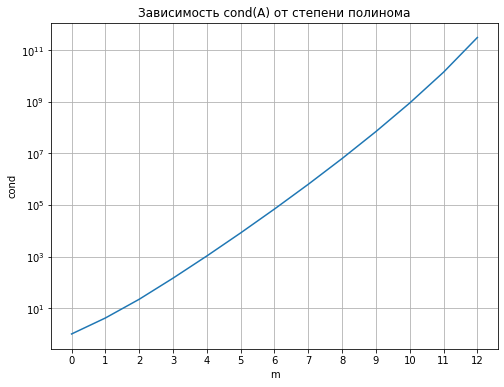

In [13]:
cond = []
for m in range(M+1):
    cond.append( np.linalg.cond(get_design_matrix(x, m)) )
    
plt.figure(figsize=(8,6))
plt.plot(list(range(M+1)), cond)
plt.xticks(list(range(M+1)))
plt.xlabel('m')
plt.ylabel('cond')
plt.title('Зависимость cond(A) от степени полинома')
plt.grid()
plt.yscale('log')

Зависимость экспоненциальная, в то время как число обусловленности для левой части нормальной системы МНК
:
$$ cond(A^T A) = cond(A)^2,$$
что, несомненно, несколько сказывается на точности аппроксимации.

#### Задание 5.2.4

В таблице приведены результаты наблюдений за перемещением x материальной точки по оси $Ох$ в моменты времени $t \in [t_0 ,T]$. Известно, что движение является равномерным и описывается линейной зависимостью: $$x(t)=vt+b$$ Используя метод наименьших квадратов, определить скорость $v$ и спрогнозировать положение точки в момент времени $t=2T$. На одном чертеже построить график движения точки и точечный график исходных наблюдений.

1) Задание таблицы наблюдений:

In [23]:
t = np.array([0, 0.6, 1.2, 1.8, 2.4, 3, 4.2, 4.8, 5.4, 6])
x = np.array([6.449, 19.97, 33.97, 48.2, 64.15, 76.9, 106.2, 122.2, 135.6, 149])

2) Решение нормальной системы:

In [33]:
coeffs = solve_normal_equations(get_design_matrix(t, 1), x)

Скорость $v$ материальной точки равна:

In [39]:
v = coeffs[1]
b = coeffs[0]
print("Скорость v материальной точки равна %f" % v)
print("Смещение b равно %f" % b)

Скорость v материальной точки равна 23.998759
Смещение b равно 5.707549


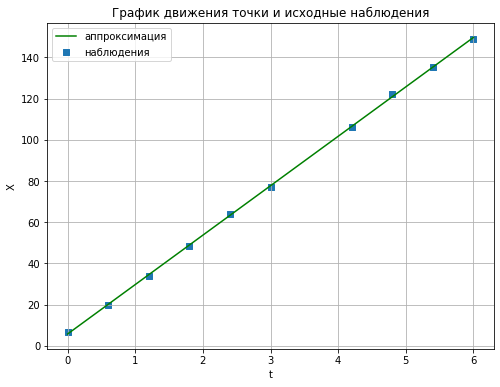

In [48]:
line = np.poly1d(coeffs[::-1])

plt.figure(figsize=(8, 6))

plt.scatter(t, x, label='наблюдения', marker='s')
plt.plot(t, line(t), label='аппроксимация', c='g')
plt.xlabel('t')
plt.ylabel('X')
plt.title('График движения точки и исходные наблюдения')
plt.grid()
plt.legend()
plt.show()

3) Прогнозирование положения точки в момент времени $t=2T$: 

In [56]:
T = max(t)
print("Положение точки в момент времени t = 2T = %d: %f" % (2*T, line(2*T)))

Положение точки в момент времени t = 2T = 12: 293.692655


#### Задание 5.6.11

Дана функция $y=f(x)$. Приблизить $f(x)$ на отрезке $[a, b]$ интерполяционными многочленами Лагранжа 1, 2, 3 степеней. На одном чертеже построить графики приближающих многочленов и функции f(x). Для многочлена 3 степени сравнить качество приближения при различном выборе узлов интерполяции.

$$ f(x) = x^2 cos(x), x \in [\frac{\pi}{2}, \pi]$$

1) Задание функции и границ отрезка:

In [84]:
f = lambda x: x**2 * np.cos(x)
a = np.pi/2
b = np.pi

2) Определение функций для вычисления значений многочлена Лагранжа:

Многочлен Лагранжа имеет вид:
$$ P(x) = \sum_{k=0}^m y_k l_k(x)$$ <br>
где $l_k(x)$ $-$ элементарный многочлен Лагранжа степени m, который вычисляется по формуле:
$$ l_k(x) = \prod_{j=0, j\neq k}^m \frac{x - x_j}{x_k - x_j}$$ <br>
и обладает свойством:
\begin{equation}
l_k(x_j) = 
 \begin{cases}
   1, &k = j\\
   0, &k \neq j
 \end{cases}
\end{equation}

In [101]:
def lagrange_elpoly(x, nodes, k):
    # элементарный многочлен Лагранжа
    # x - точка, в которой считается значение многочлена
    # nodes - узлы интерполяции
    # k - номер многочлена (индекс какой точки будет в знаменателях)
    value = 1.0
    for i in range(len(nodes)):
        if i == k:
            continue
        value *= (x - nodes[i])/(nodes[k] - nodes[i])
        
    return value

def lagrange(x, nodes, y):
    # x - точка, в которой считается значение многочлена Лагранжа
    # nodes - точки интерполяции
    # y - значения интерполируемой функции в узлах интерполяции
    return np.sum([y[j]*lagrange_elpoly(x, nodes, j) for j in range(len(nodes))])

3) График для многочленов степени $m = 1, 2, 3$ с равномерной сеткой узлов интерполяции:

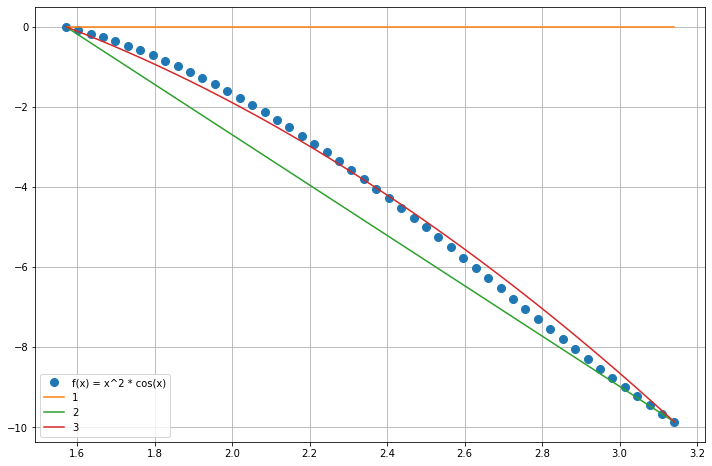

In [108]:
x_space = np.linspace(a, b)

plt.figure(figsize=(12, 8))
plt.plot(x_space, f(x_space), 'o', markersize=8, label='f(x) = x^2 * cos(x)')

for m in range(1, 4):
    nodes = np.linspace(a, b, m)
    plt.plot(x_space, [lagrange(x_, nodes, f(nodes)) for x_ in x_space], label=m)
plt.grid()
plt.legend()
plt.show()

4) Сравнение качества интерполяции для многочленов степени $m=3$ при различном выборе узлов интерполяции:

Рассматриваются три варианта: 
- равномерная сетка узлов
- произвольный выбор узлов
- узлы Чебышева

функция, возвращающая узлы Чебышева для указанного отрезка $[a, b]$ и степени $n$:

In [109]:
def chebyshev_nodes(a, b, n):
    nodes = []
    for i in range(n):
        x = 0.5*(a+b) + 0.5*(b-a)*np.cos((2*i+1)*np.pi/(2*n))
        nodes.append(x)
        
    return np.array(nodes)

In [110]:
m_ = 3

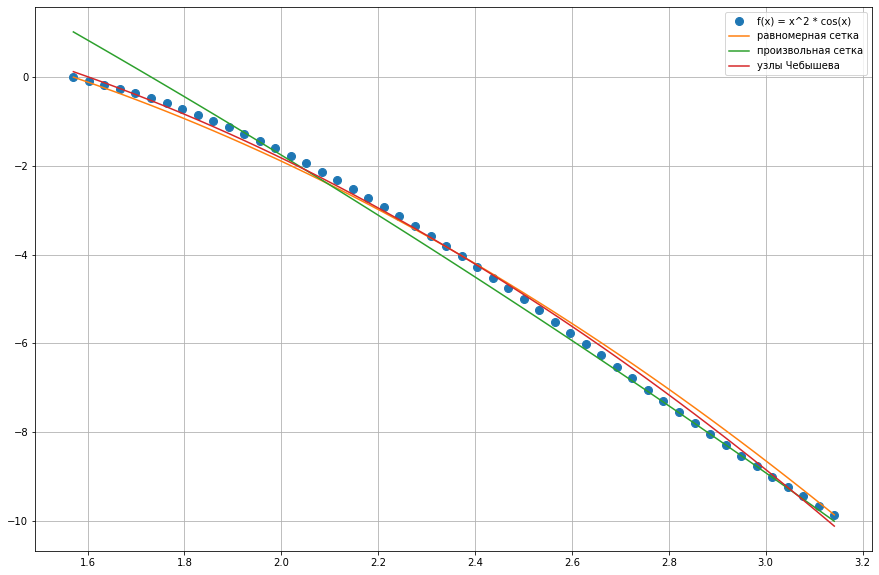

In [115]:
nodes = np.linspace(a, b, m_)
rand_nodes = np.random.uniform(a, b, m_)
cheb_nodes = chebyshev_nodes(a, b, m_)

plt.figure(figsize=(15, 10))
plt.plot(x_space, f(x_space), 'o', markersize=8, label='f(x) = x^2 * cos(x)')

plt.plot(x_space, [lagrange(x_, nodes, f(nodes)) for x_ in x_space], label='равномерная сетка')
plt.plot(x_space, [lagrange(x_, rand_nodes, f(rand_nodes)) for x_ in x_space], label='произвольная сетка')
plt.plot(x_space, [lagrange(x_, cheb_nodes, f(cheb_nodes)) for x_ in x_space], label='узлы Чебышева')
plt.grid()
plt.legend()
plt.show()

In [126]:
for label, nd in zip(['Равномерные узлы', 'Произвольные узлы', 'узлы Чебышева'], [nodes, rand_nodes, cheb_nodes]):
    mse = (np.square( f(x_space) - np.array([lagrange(x_, nd, f(nd)) for x_ in x_space]) )).mean()
    print("%s: mse = %f" % (label, mse))

Равномерные узлы: mse = 0.044899
Произвольные узлы: mse = 0.098419
узлы Чебышева: mse = 0.018943


Как видно из графика и значений среднеквадратичных ошибок, качество интерполяции при выборе узлов Чебышева наивысшая.